# Neuralized Belief Approximation for Toy LDPC Decoding (AWGN)

This notebook accompanies Section **Neural Decoding of LDPC Codes**.

It compares three decoders on a *toy* LDPC code:

1. **Exact posterior marginals** computed by enumeration (feasible here because \(n\) is small).
2. **Classical sum–product BP** on the Tanner graph (iterative message passing).
3. **Amortized neural marginal decoder** trained to predict bitwise posterior marginals directly from the channel output \(y\).

All figures are **shown inline** and also **saved** to `figs/`.


In [1]:
# 0) Imports and figure directory
import os
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

os.makedirs("figs", exist_ok=True)

np.random.seed(0)
torch.manual_seed(0)


## 1) Toy LDPC code (parity-check matrix) and Tanner graph

A binary vector \(x\in\{0,1\}^n\) is a valid codeword iff \(Hx=0 \pmod 2\).
From \(H\) we build Tanner graph neighborhoods:
- bit-to-check neighbors \(\mathcal{N}(i)\)
- check-to-bit neighbors \(\mathcal{N}(c)\)


In [2]:
# Parity-check matrix (toy LDPC)
H = np.array([
    [1,1,1,0,0,0,0,0],
    [0,0,1,1,1,0,0,1],
    [1,0,0,0,0,1,1,0],
    [0,1,0,1,0,1,0,1]
], dtype=np.int64)

m, n = H.shape
print("H shape:", H.shape)

check_nbrs = [list(np.where(H[c] == 1)[0]) for c in range(m)]   # bits in check c
bit_nbrs   = [list(np.where(H[:,i] == 1)[0]) for i in range(n)] # checks touching bit i

print("check_nbrs:", check_nbrs)
print("bit_nbrs  :", bit_nbrs)


H shape: (4, 8)
check_nbrs: [[0, 1, 2], [2, 3, 4, 7], [0, 5, 6], [1, 3, 5, 7]]
bit_nbrs  : [[0, 2], [0, 3], [0, 1], [1, 3], [1], [2, 3], [2], [1, 3]]


## 2) AWGN channel model and exact posterior marginals

We use BPSK mapping \(\mu_{x_i}=1-2x_i\) so that:
- \(x_i=0\mapsto +1\)
- \(x_i=1\mapsto -1\)

AWGN:
\[
y_i = \mu_{x_i} + z_i,\qquad z_i\sim\mathcal{N}(0,\sigma^2).
\]

For this small code we can compute the **exact posterior** by enumerating all valid codewords
and then extracting exact bitwise marginals \(p(x_i=1\mid y)\).


In [3]:
def is_valid_codeword(x_bits: np.ndarray) -> bool:
    return np.all((H @ x_bits) % 2 == 0)

# Enumerate all valid codewords (small n)
all_codewords = []
for bits in itertools.product([0,1], repeat=n):
    x = np.array(bits, dtype=np.int64)
    if is_valid_codeword(x):
        all_codewords.append(x)
all_codewords = np.stack(all_codewords, axis=0)
print("Number of valid codewords:", all_codewords.shape[0])

def bpsk(x_bits: np.ndarray) -> np.ndarray:
    return 1.0 - 2.0*x_bits  # 0 -> +1, 1 -> -1

def awgn(signal: np.ndarray, sigma: float, rng=np.random) -> np.ndarray:
    return signal + sigma*rng.standard_normal(*signal.shape)

def exact_posterior_bit_marginals(y: np.ndarray, sigma: float):
    """Return p1 (n,), logZ (scalar), and normalized weights over valid codewords."""
    S = bpsk(all_codewords)  # (Ncw, n)
    diff2 = np.sum((y[None,:] - S)**2, axis=1)
    logw = -diff2/(2*sigma**2)
    logw = logw - np.max(logw)  # stabilize
    w = np.exp(logw)
    w = w / np.sum(w)
    p1 = np.sum(w[:,None]*all_codewords, axis=0)  # E[x_i | y] since x_i in {0,1}
    logZ = np.log(np.sum(np.exp(-diff2/(2*sigma**2))))
    return p1, logZ, w


Number of valid codewords: 16


## 3) Classical BP (sum–product) in LLR form

Channel LLR for our BPSK convention:
\[
\mathrm{LLR}_i = \log\frac{p(x_i=0\mid y_i)}{p(x_i=1\mid y_i)} = \frac{2y_i}{\sigma^2}.
\]

Sum–product BP updates in LLR form:
- Bit→Check:
\[
m_{i\to c} = \mathrm{LLR}_i + \sum_{c'\in\mathcal{N}(i)\setminus c} m_{c'\to i}.
\]
- Check→Bit (tanh rule):
\[
m_{c\to i} = 2\,\mathrm{atanh}\!\Bigl(\prod_{j\in\mathcal{N}(c)\setminus i} \tanh(m_{j\to c}/2)\Bigr).
\]

Posterior marginal:
\[
p(x_i=1\mid y) \approx \sigma\!\bigl(-\mathrm{LLR}^{\mathrm{post}}_i\bigr),
\qquad
\mathrm{LLR}^{\mathrm{post}}_i = \mathrm{LLR}_i + \sum_{c\in\mathcal{N}(i)} m_{c\to i}.
\]


In [4]:
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def bp_decode_bit_marginals(y: np.ndarray, sigma: float, n_iters: int = 20, clip: float = 20.0):
    llr = (2.0*y)/(sigma**2)

    m_i2c = {(i,c): llr[i] for i in range(n) for c in bit_nbrs[i]}
    m_c2i = {(c,i): 0.0    for c in range(m) for i in check_nbrs[c]}

    def atanh_safe(x):
        x = np.clip(x, -0.999999, 0.999999)
        return 0.5*np.log((1+x)/(1-x))

    for _ in range(n_iters):
        # check -> bit
        for c in range(m):
            bits = check_nbrs[c]
            for i in bits:
                prod = 1.0
                for j in bits:
                    if j == i:
                        continue
                    prod *= np.tanh(0.5*np.clip(m_i2c[(j,c)], -clip, clip))
                m_c2i[(c,i)] = 2.0*atanh_safe(prod)

        # bit -> check
        for i in range(n):
            checks = bit_nbrs[i]
            for c in checks:
                s = llr[i]
                for cp in checks:
                    if cp == c:
                        continue
                    s += m_c2i[(cp,i)]
                m_i2c[(i,c)] = np.clip(s, -clip, clip)

    llr_post = np.zeros(n)
    for i in range(n):
        llr_post[i] = llr[i] + sum(m_c2i[(c,i)] for c in bit_nbrs[i])

    p1 = sigmoid(-llr_post)  # P(bit=1) = sigmoid(-LLR)
    return p1, llr_post


## 4) Amortized neural marginal decoder (local graph-aware features)

We train a small network to predict bitwise marginals without running BP iterations.

Per-bit feature vector includes:
- the local observation \(y_i\)
- for each neighboring check \(c\in\mathcal{N}(i)\): the sum of observations on the *other* bits in that check,
  \(\sum_{j\in\mathcal{N}(c)\setminus i} y_j\).

Training target is the **exact** posterior marginal from enumeration.


In [5]:
def bit_features_from_y(y: np.ndarray):
    max_deg = max(len(bit_nbrs[i]) for i in range(n))
    feats = np.zeros((n, 1+max_deg), dtype=np.float32)
    for i in range(n):
        feats[i,0] = y[i]
        for k, c in enumerate(bit_nbrs[i]):
            s = 0.0
            for j in check_nbrs[c]:
                if j != i:
                    s += y[j]
            feats[i,1+k] = s
    return feats

# sanity check
sigma = 0.7
x0 = all_codewords[np.random.randint(all_codewords.shape[0])]
y0 = awgn(bpsk(x0), sigma)
print("example x:", x0)
print("example y:", np.round(y0,3))
print("features shape:", bit_features_from_y(y0).shape)


example x: [1 1 0 0 0 1 0 0]
example y: [-0.214 -0.788  1.05   1.051  0.004  0.064  0.796  0.907]
features shape: (8, 3)


In [6]:
class MarginalNN(nn.Module):
    def __init__(self, in_dim: int, hidden: int = 48):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1),
            nn.Sigmoid(),
        )

    def forward(self, feats):
        # feats: (B, n, in_dim)
        B, nbits, d = feats.shape
        out = self.net(feats.reshape(B*nbits, d)).reshape(B, nbits)
        return out

def make_dataset(num_samples: int, sigma: float, rng=np.random):
    Ys = np.zeros((num_samples, n), dtype=np.float32)
    Tm = np.zeros((num_samples, n), dtype=np.float32)  # exact marginals p(bit=1|y)
    for k in range(num_samples):
        x = all_codewords[rng.integers(all_codewords.shape[0])]
        y = awgn(bpsk(x), sigma, rng=rng)
        p1_exact, _, _ = exact_posterior_bit_marginals(y, sigma)
        Ys[k] = y
        Tm[k] = p1_exact.astype(np.float32)
    return Ys, Tm

def build_feat_batch(Y):
    feats = np.stack([bit_features_from_y(y) for y in Y], axis=0)  # (B,n,in_dim)
    return torch.tensor(feats, dtype=torch.float32)


epoch   20  train MSE=8.1101e-02  test MSE=7.6931e-02
epoch   40  train MSE=4.5685e-02  test MSE=4.4890e-02
epoch   60  train MSE=4.0625e-02  test MSE=3.9872e-02
epoch   80  train MSE=3.8599e-02  test MSE=3.7687e-02
epoch  100  train MSE=3.7129e-02  test MSE=3.6158e-02
epoch  120  train MSE=3.5990e-02  test MSE=3.5020e-02
epoch  140  train MSE=3.5157e-02  test MSE=3.4226e-02
epoch  160  train MSE=3.4589e-02  test MSE=3.3707e-02
epoch  180  train MSE=3.4218e-02  test MSE=3.3377e-02
epoch  200  train MSE=3.3982e-02  test MSE=3.3168e-02
epoch  220  train MSE=3.3834e-02  test MSE=3.3035e-02
epoch  240  train MSE=3.3739e-02  test MSE=3.2948e-02
epoch  260  train MSE=3.3673e-02  test MSE=3.2889e-02
epoch  280  train MSE=3.3622e-02  test MSE=3.2844e-02
epoch  300  train MSE=3.3579e-02  test MSE=3.2809e-02
epoch  320  train MSE=3.3544e-02  test MSE=3.2780e-02
epoch  340  train MSE=3.3513e-02  test MSE=3.2756e-02
epoch  360  train MSE=3.3486e-02  test MSE=3.2736e-02
epoch  380  train MSE=3.3462

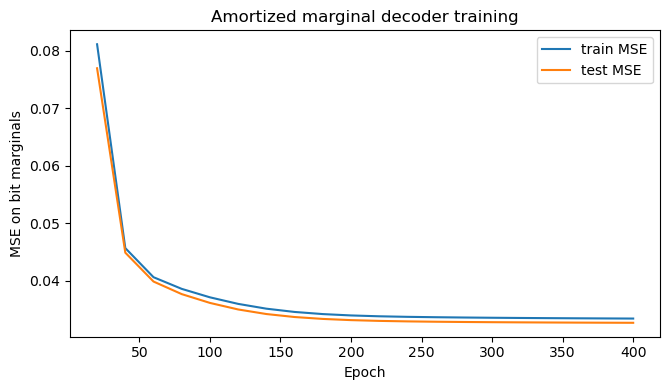

In [7]:
# Train the amortized marginal network
sigma_train = 0.7
N_train, N_test = 4000, 800

Ytr, Ttr = make_dataset(N_train, sigma_train, rng=np.random.default_rng(1))
Yte, Tte = make_dataset(N_test,  sigma_train, rng=np.random.default_rng(2))

max_deg = max(len(bit_nbrs[i]) for i in range(n))
in_dim = 1 + max_deg

Xtr = build_feat_batch(Ytr)
Xte = build_feat_batch(Yte)
Ttr_t = torch.tensor(Ttr, dtype=torch.float32)
Tte_t = torch.tensor(Tte, dtype=torch.float32)

model = MarginalNN(in_dim=in_dim, hidden=48)
opt = optim.Adam(model.parameters(), lr=2e-3)

def mse(a,b): 
    return ((a-b)**2).mean()

train_losses=[]
test_losses=[]
epochs=[]

for epoch in range(1, 401):
    model.train()
    opt.zero_grad()
    pred = model(Xtr)
    loss = mse(pred, Ttr_t)
    loss.backward()
    opt.step()

    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            pred_te = model(Xte)
            loss_te = mse(pred_te, Tte_t).item()
        epochs.append(epoch)
        train_losses.append(loss.item())
        test_losses.append(loss_te)
        print(f"epoch {epoch:4d}  train MSE={loss.item():.4e}  test MSE={loss_te:.4e}")

plt.figure(figsize=(6.8,4.0))
plt.plot(epochs, train_losses, label="train MSE")
plt.plot(epochs, test_losses, label="test MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE on bit marginals")
plt.title("Amortized marginal decoder training")
plt.legend()
plt.tight_layout()
plt.savefig("figs/ldpc_nn_training_curve.png", dpi=150)
plt.show()


## 5) Main comparison figure: Exact vs BP vs Neural

We pick a single test instance \(y\) and compare the three posterior marginal vectors
\(p(x_i=1\mid y)\). The resulting plot is saved as:

- `figs/ldpc_posterior_means.png`


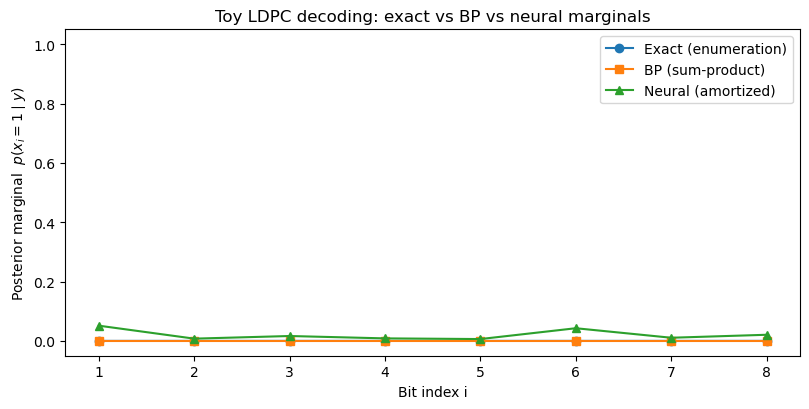

Transmitted x (0/1): [0 0 0 0 0 0 0 0]
Channel y: [0.743 1.902 1.136 1.644 1.404 0.554 1.379 0.778]


In [8]:
# Pick one instance and compare
rng = np.random.default_rng(123)
x = all_codewords[rng.integers(all_codewords.shape[0])]
y = awgn(bpsk(x), sigma_train, rng=rng)

p_exact, _, _ = exact_posterior_bit_marginals(y, sigma_train)
p_bp, _ = bp_decode_bit_marginals(y, sigma_train, n_iters=25)

model.eval()
with torch.no_grad():
    feats = torch.tensor(bit_features_from_y(y)[None,:,:], dtype=torch.float32)
    p_nn = model(feats).numpy().reshape(-1)

idx = np.arange(1, n+1)

plt.figure(figsize=(8.2,4.2))
plt.plot(idx, p_exact, marker="o", label="Exact (enumeration)")
plt.plot(idx, p_bp, marker="s", label="BP (sum-product)")
plt.plot(idx, p_nn, marker="^", label="Neural (amortized)")

plt.ylim(-0.05, 1.05)
plt.xlabel("Bit index i")
plt.ylabel(r"Posterior marginal  $p(x_i=1\mid y)$")
plt.title("Toy LDPC decoding: exact vs BP vs neural marginals")
plt.legend()
plt.tight_layout()
plt.savefig("figs/ldpc_bit_marginals.png", dpi=150)
plt.show()

print("Transmitted x (0/1):", x)
print("Channel y:", np.round(y,3))


Selected codeword x_true (0/1): [0 0 0 0 1 1 1 1]  (#ones = 4 )
sigma_demo: 1.2
Channel observation y_demo: [ 0.559  2.546  1.233  2.104 -0.307 -1.764 -0.35  -1.38 ]


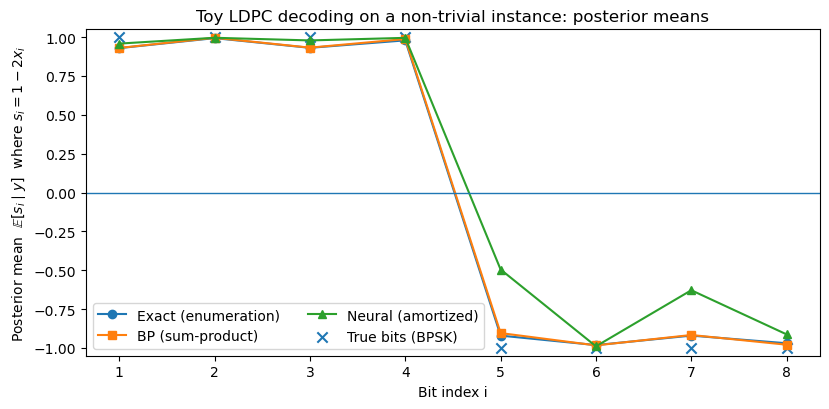

In [9]:

# Pick a *non-trivial* test instance = nonzero codeword ... and compare (more informative visualization)

def pick_balanced_codeword(all_codewords: np.ndarray, rng, min_ones: int = 2, max_ones: int = None):
    """Pick a codeword that is neither all-zeros nor all-ones (ideally mixed 0/1)."""
    n = all_codewords.shape[1]
    if max_ones is None:
        max_ones = n - 2
    pool = [x for x in all_codewords if (min_ones <= int(x.sum()) <= max_ones)]
    if len(pool) == 0:
        pool = [x for x in all_codewords if int(x.sum()) > 0]
    return pool[rng.integers(len(pool))]

rng_vis = np.random.default_rng(123)

# 1) Choose a non-trivial codeword
x_true = pick_balanced_codeword(all_codewords, rng_vis)
print("Selected codeword x_true (0/1):", x_true, " (#ones =", int(x_true.sum()), ")")

# 2) Use a slightly larger noise level for visualization (to show uncertainty)
sigma_demo = 1.2
y_demo = awgn(bpsk(x_true), sigma_demo, rng=rng_vis)
print("sigma_demo:", sigma_demo)
print("Channel observation y_demo:", np.round(y_demo, 3))

# 3) Compute exact / BP / neural posterior bit-marginals
p_exact, _, _ = exact_posterior_bit_marginals(y_demo, sigma_demo)
p_bp, _ = bp_decode_bit_marginals(y_demo, sigma_demo, n_iters=25)

model.eval()
with torch.no_grad():
    feats = torch.tensor(bit_features_from_y(y_demo)[None, :, :], dtype=torch.float32)
    p_nn = model(feats).numpy().reshape(-1)

# 4) Convert p(x_i=1|y) to posterior means in {-1,+1}:
#    s_i = 1 - 2 x_i  so  E[s_i|y] = 1 - 2 p(x_i=1|y)
m_exact = 1.0 - 2.0*p_exact
m_bp    = 1.0 - 2.0*p_bp
m_nn    = 1.0 - 2.0*p_nn
s_true  = 1.0 - 2.0*x_true

idx = np.arange(1, n+1)

plt.figure(figsize=(8.4, 4.2))
plt.plot(idx, m_exact, marker="o", label="Exact (enumeration)")
plt.plot(idx, m_bp,    marker="s", label="BP (sum-product)")
plt.plot(idx, m_nn,    marker="^", label="Neural (amortized)")
plt.scatter(idx, s_true, s=55, marker="x", label="True bits (BPSK)")

plt.axhline(0.0, linewidth=1)
plt.ylim(-1.05, 1.05)
plt.xlabel("Bit index i")
plt.ylabel(r"Posterior mean  $\mathbb{E}[s_i \mid y]$  where $s_i=1-2x_i$")
plt.title("Toy LDPC decoding on a non-trivial instance: posterior means")
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig("figs/ldpc_posterior_means.png", dpi=150)
plt.show()


## Notes / suggested extensions (for the exercise)

1. **Generalization across SNR.** Train at one \(\sigma\) and test at another.
2. **Consistency penalties.** Introduce check-wise beliefs and a soft consistency penalty,
   then compare to the simpler marginal network used here.
3. **Unrolled BP.** Replace fixed BP iterations by an unrolled network with trainable damping/weights.
4. **GNN decoder.** Replace hand-crafted features by a message-passing GNN on the Tanner graph.
